# Penalized Regression

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.copy_on_write = True
import patsy as pt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from IPython.display import Image
from sklearn.metrics import confusion_matrix

## Why penalized regression?

In [46]:
# github.com/roualdes/data -> penguins
df = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/refs/heads/master/penguins.csv")

In [47]:
df["biscoe"] = df["island"] == "Biscoe"
df["biscoe"] = df["biscoe"].astype("int64")
df2 = df.dropna(subset = ["biscoe", "bill_depth_mm"])
y, X = pt.dmatrices("biscoe ~ 0 + bill_depth_mm", df2) # 0 + => No intercept
y = np.reshape(y, -1)

In [48]:
fit = LogisticRegression(penalty = None).fit(X, y)
(fit.intercept_, fit.coef_[0])

(array([16.35154689]), array([-0.95413577]))

In [49]:
approx_accuracy = cross_val_score(LogisticRegression(), X, y)
approx_accuracy

array([0.53623188, 0.8115942 , 0.82352941, 0.91176471, 0.89705882])

In [50]:
np.mean(approx_accuracy)

0.7960358056265985

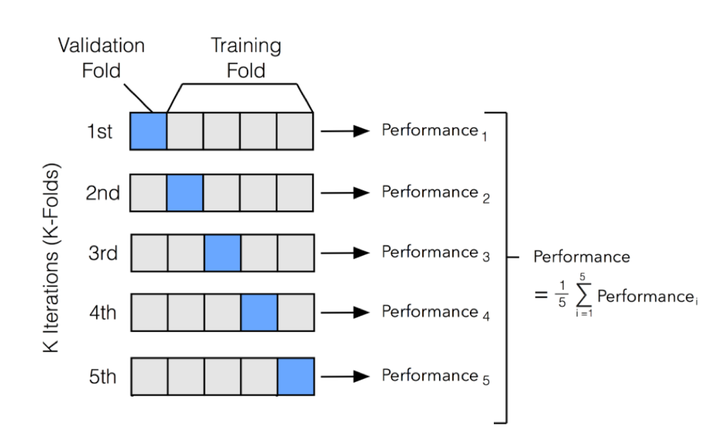

In [51]:
Image("https://zitaoshen.rbind.io/project/machine_learning/machine-learning-101-cross-vaildation/featured_hubbc3c90efda00133c9815a673162bf54_130575_720x0_resize_lanczos_2.png")

In [52]:
lambdas = np.logspace(0, 5, 101)

In [53]:
approx_accuracy = np.zeros_like(lambdas)
for li, l in enumerate(lambdas):
    cv_approx = cross_val_score(LogisticRegression(C = 1 / l), X, y)
    approx_accuracy[li] = np.mean(cv_approx)

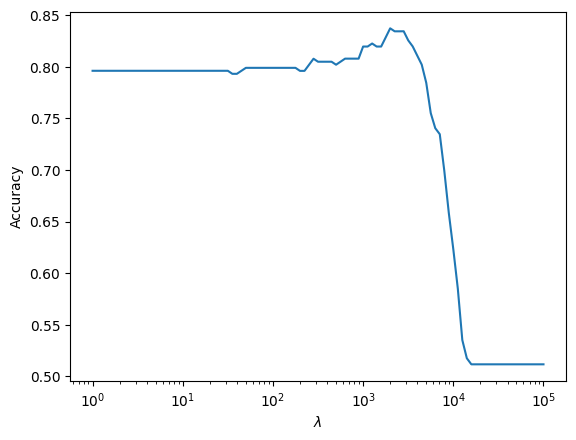

In [54]:
plt.plot(lambdas, approx_accuracy, label = "Accuracy");
plt.xscale("log")
plt.ylabel("Accuracy")
plt.xlabel("$\\lambda$");

Conclusion: There are some values of the penalty parameter $\lambda$ that can improve your models predictive capabilities on data your model has not yet seen.

## Which Penalty Term is Best?

* L2 Penalty: $\text{log\_likelihood}(\beta_{0:K}) + \lambda \sum_{j=1}^K \beta_j^2$
Sometimes called Ridge Regression in the context of linear regression, but not logistic
* L1 Penalty / Lasso: $\text{log\_likelihood}(\beta_{0:K}) + \lambda \sum_{j=1}^K |\beta_j|$
* ElasticNet Penalty: $\text{log\_likelihood}(\beta_{0:K}) + \lambda ( \alpha \sum_{j=1}^K |\beta_j| + (1 - \alpha) \sum_{j=1}^K \beta_j^2)$

for $\lambda \geq 0$ and $\alpha \in [0, 1]$


I don't think there is a generally accepted best here; context matters.  The L2 penalty will ~~never~~ rarely(?) make coefficients exactly equal to zero, while the L1 will [eagerly make coefficients exactly equal to zero](https://explained.ai/regularization/index.html).

In some contexts, ruling out some coefficients as meaningful variables for prediction can be a meaningful conclusion.  Genetics comes to mind.  Other times, the sharp corner of the L1 penalty can be annoying to deal with.  All of Bayesian statistics comes to mind.

The ElasticNet penalty was meant to settle the debate between L1 and L2 penalties, but I don't believe it has.  By introducing the variable $\alpha$, there is yet more cross-validaiton work to be done.

Conclusion: Best here depends on the context.  If you really want some coefficients set to identically zero, use L1.  Otherwise, use L2.

## How To Choose The Magnitude Of The Penalty Term

1. Normalize predictors
   * not explanatory variables
2. perform cross validation
   * using the appropraite metric for you dataset
3. choose the value of lambda that optimizes the cross validation metric

In [55]:
sigmas = np.std(X, axis = 0)
X_std = X / sigmas
lambdas = np.logspace(0, 5, 101)
approx_accuracy = np.zeros_like(lambdas)
for li, l in enumerate(lambdas):
    cv_approx = cross_val_score(LogisticRegression(C = 1 / l), X_std, y)
    approx_accuracy[li] = np.mean(cv_approx)
li_star = np.argmax(approx_accuracy)
lambda_star = lambdas[li_star]
fit = LogisticRegression(C = 1 / lambda_star).fit(X_std, y)

| Actual / Predicted | 0 | 1 |
|-------------------|---|---|
| 0 | True Negative 🥳 | False Positive 😵‍💫 |
| 1 | False Negative 😵‍💫 | True Positive 🥳 | 

In [56]:
confusion_matrix(df2["biscoe"], fit.predict(X_std), normalize = "all")

array([[0.49122807, 0.02046784],
       [0.14035088, 0.34795322]])